# Comparing Air Quality Measures in New York City: Sensors on the Ground and from Space

## Overview

In this lesson we use a recent wildfire smoke event affecting New York City as a case study to compare how different air quality measurement systems observe the same episode. 

In early November 2024, a series of wildfires in New Jersey and the lower Hudson Valley New York sent smoke drifting across the river into New York City. Over several days, the skyline took on a hazy, orange tint as fine particulate matter (PM₂.₅) increased across the region. Residents reported the smell of smoke, reduced visibility, and air quality alerts, even though the fires themselves were burning tens of kilometers away.

<img src="./images/PIP_Fire_NYT.jpg" alt="PIP Wildfire" width="1000"/>



This event gives us a clear, concrete case study for comparing how **different air quality measurement systems** capture the same episode. Our focus is on four complementary sources of information:

- **Crowd-sourced, low-cost sensors** operated by individuals and community groups (PurpleAir).
- **Medium-cost, grant-funded community networks** deployed with partner organizations (QuantAQ).
- **Official monitoring networks** operated by government agencies (EPA monitors and the NYC Community Air Survey / NYCCAS).
- **Space-based remote sensing** from NASA’s TEMPO mission, observing air quality from geostationary orbit.

Rather than demonstrating every API in detail, this notebook works with **prepared datasets** from each system. You will load these datasets, align them to a **common schema**, and explore how their temporal and spatial patterns compare during the smoke event. Along the way, you will begin to develop intuition about when each type of measurement is most useful, and what its limitations are for understanding air quality in New York City. 

---

## Learning objectives

By the end of this activity, you should be able to:

1. **Describe the main differences** between four types of air quality measurements in New York City:
   - Crowd-sourced, low-cost sensors (PurpleAir),
   - Community-deployed, medium-cost instruments (QuantAQ),
   - Official monitoring networks (EPA and NYCCAS),
   - Space-based remote sensing (NASA TEMPO).

2. **Load prepared datasets** from each of these systems into Python and align them to a **common schema** using consistent timestamps, units, and column names.

3. **Compare temporal patterns** in PM₂.₅ (and related indicators) across sources during a wildfire smoke event, using time series plots and daily summary statistics.

4. **Compare spatial patterns** across sources by mapping sensor locations and event-period concentrations over New York City.

5. **Reflect on strengths and limitations** of each measurement approach, including issues of accuracy, coverage, spatial resolution, and accessibility for communities.

---


## Learn More - Air Quality Data Acquisition Notebooks

Although the focus of the lesson is on using these data. The repository also includes Jupyter notebooks for acquiring air quality measurements from each of the sources we consider:

- **EPA**: [`m201-air-quality-measures-acquire-epa.ipynb`](m201-air-quality-measures-acquire-epa.ipynb)  
  Retrieves data from the Environmental Protection Agency (EPA).

- **PurpleAir**: [`m201-air-quality-measures-acquire-purpleair.ipynb`](m201-air-quality-measures-acquire-purpleair.ipynb)  
  Collects sensor data from the PurpleAir network.

- **QuantAQ**: [`m201-air-quality-measures-acquire-quantaq.ipynb`](m201-air-quality-measures-acquire-quantaq.ipynb)  
  Interfaces with QuantAQ devices for air quality readings.

- **TEMPO**: [`m201-air-quality-measures-acquire-tempo.ipynb`](m201-air-quality-measures-acquire-tempo.ipynb)  
  Accesses satellite-based air quality data from the TEMPO mission.

---

## Programming reminder and setup

This activity is designed to be run in a Jupyter notebook (for example in VS Code, JupyterLab, or a browser-based environment). Before you start working with the code cells below, keep the following points in mind:

- You run a code cell by selecting it and pressing **Shift + Enter** (or using the “Run” button in your interface).
- The order in which you run cells matters. If you restart the kernel, you will need to re-run any cells that define variables, import libraries, or load data.
- If you encounter an error, read the message carefully. Often it will indicate a missing package, a typo in a variable name, or a cell that needs to be re-run.

In this notebook we will:

- Import a small set of Python packages for working with tables, dates, and maps.
- Set a few **analysis parameters**, including:
  - The start and end dates of the wildfire smoke episode,
  - A bounding box that approximates the New York City region,
  - File paths to prepared datasets for PurpleAir, QuantAQ, EPA/NYCCAS, and TEMPO.

All data access in this integrated notebook is **offline**. We assume that separate notebooks have already been used to download and pre-process data from each source (for example, the PurpleAir and QuantAQ API notebooks), and that the resulting files are available on disk for you to read here.


## Required Python modules and analysis parameters

In this section we import the Python packages that we will use throughout the notebook and define a small set of analysis parameters. These parameters include the date range of the wildfire smoke episode, an approximate bounding box for the New York City region, and file paths to the prepared datasets for each data source.


In [37]:
# Required Python modules and analysis parameters

from pathlib import Path
from datetime import datetime
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

try:
    import geopandas as gpd
    from shapely.geometry import Point
    import contextily as cx
except ImportError:
    gpd = None
    cx = None
    print("Install geopandas/shapely/contextily for basemap maps.")


# Event window for this lesson (NYC wildfire smoke episode)
EVENT_START_DATE = "2024-11-07"
EVENT_END_DATE   = "2024-11-10"

# New York City bounding box (WGS84)
# (min_lon, min_lat, max_lon, max_lat)
NYC_BBOX = (-74.2591, 40.4774, -73.7004, 40.9176)

# -------------------------------------------------------------------
# Base directories
# -------------------------------------------------------------------
BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Per-source raw dirs (from your screenshot)
EPA_RAW_DIR       = RAW_DIR / "epa"
PURPLEAIR_RAW_DIR = RAW_DIR / "purpleair"
QUANTAQ_RAW_DIR   = RAW_DIR / "quantaq"
TEMPO_RAW_DIR     = RAW_DIR / "tempo"

# -------------------------------------------------------------------
# Event-window files (Parquet-first; CSV copies are optional)
# -------------------------------------------------------------------

# EPA AQS PM2.5 event table + site metadata
EPA_EVENT = EPA_RAW_DIR / "epa_pm25_nyc_20241107_10.parquet"
EPA_SITES = EPA_RAW_DIR / "NYC_EPA_AQS_sites_eventwindow_20241107_10.parquet"

# PurpleAir per-sensor event files + metadata
PURPLEAIR_EVENT_PATTERN = "PurpleAir_sensor_*_2024_11_07_to_11_10.parquet"
PURPLEAIR_META          = PURPLEAIR_RAW_DIR / "SouthBronxPurpleAirSensors.parquet"
# (GeoParquet SouthBronxPurpleAirSensors_geo.parquet is for GIS workflows.)

# QuantAQ event table + device metadata
QUANTAQ_EVENT   = QUANTAQ_RAW_DIR / "SouthBronx_QuantAQ_2024_11_07_to_11_10.parquet"
QUANTAQ_DEVICES = QUANTAQ_RAW_DIR / "SouthBronxQuantAQDevices.parquet"

# TEMPO NO2 L3 sample file (covers NYC during event)
TEMPO_FILE = TEMPO_RAW_DIR / "TEMPO_NO2_L3_V03_20241109T192221Z_S010.nc"

## Sensor ecosystem in this lesson

In this notebook we work with four complementary ways of measuring air quality in and around New York City. Each comes from a different type of instrument and organization, and each has different strengths and limitations.

| System type | Example in this lesson | Who operates it? | Typical strengths | Typical limitations |
|------------|------------------------|------------------|-------------------|---------------------|
| Crowd-sourced, low-cost sensors | **PurpleAir** | Individuals, schools, community groups | Dense spatial coverage where people choose to install sensors; relatively low cost; near real-time data | Data quality varies; siting can be ad-hoc (e.g., on balconies or near pollution sources); often requires extra cleaning and calibration |
| Community-deployed, medium-cost instruments | **QuantAQ** | Universities and partner organizations with grant support | Higher sensor quality than most low-cost devices; more controlled siting; flexible deployments for specific research or community projects | Fewer sites than low-cost networks; not an official regulatory record; requires technical capacity to deploy and maintain |
| Official monitoring networks | **EPA monitors, NYCCAS** | Government agencies and public health departments | Carefully maintained instruments; standardized methods; long-term records used for regulatory decisions and public health assessments | Sparse spatial coverage; cannot capture hyper-local variation between monitors; locations are fixed and sometimes far from where people live and work |
| Space-based remote sensing | **NASA TEMPO** | NASA and partner agencies | Wide regional coverage; consistent measurements over large areas; useful for connecting local conditions to regional and upwind sources | Coarser spatial resolution than ground sensors; indirect view of ground-level pollution; clouds and retrieval errors can limit coverage at specific times and places |

In separate notebooks, each system has its own **data acquisition workflow** (for example, calling the PurpleAir and QuantAQ APIs or downloading files from EPA). In this integrated notebook we assume those steps are complete and that **prepared datasets** from each system are available on disk. Our goal is to bring these datasets into a **common schema**, compare how they behave during the wildfire smoke event, and think critically about how they complement each other.

---


## Learn More - New York City Community Air Survey (NYCCAS)

New York City’s **Community Air Survey (NYCCAS)** is a long-running program
run by the NYC Department of Health and Mental Hygiene in partnership with
Queens College (CUNY). The goal of NYCCAS is to understand how **average air
pollution levels vary from place to place within NYC**, beyond what can be
seen from a small number of regulatory monitors. 

Key features of NYCCAS include:

- ~100 street-level monitoring locations distributed across all five boroughs,
  sampling during each season to capture **neighborhood-scale spatial patterns**.   
- Monitors mounted on light poles and other street infrastructure about 10–12 feet
  above ground, using battery-powered pumps and filters to collect samples that are
  later analyzed in a lab.   
- Measurement of multiple pollutants, including **PM₂.₅, NO, NO₂, black carbon,
  ozone, and sulfur dioxide**, with additional “environmental justice” sites in
  low-income neighborhoods that benefit from more intensive monitoring.   
- Land-use regression models that use NYCCAS measurements plus information on
  traffic, buildings, and other land-use factors to estimate **neighborhood-scale
  pollution fields** across the city, published as maps and raster data on NYC
  open-data and health portals.   

In this lesson, we **do not load NYCCAS data directly** into our common schema.
Instead, we treat NYCCAS as part of the broader **“official” air quality system**
for NYC:

- EPA AQS provides a small number of high-quality regulatory monitoring sites.
- NYCCAS provides a denser, seasonally sampled, **modeled view of neighborhood
  air quality** at street level.

Later modules or projects could integrate NYCCAS model outputs (e.g., raster maps
of PM₂.₅) with the sensor data we explore here.

---

## Common schema for this lesson

We are working with three different **ground-based air-quality data sources**:

- PurpleAir (low-cost community sensors),
- QuantAQ (research-grade community network),
- EPA AQS (official regulatory monitors).

Each source uses its own data format and naming conventions. To compare them fairly, we will map them into a **common schema**.

### Core fields

Across all three sources, we will construct the following core columns:

| Column            | Type                | Description |
|-------------------|---------------------|-------------|
| `timestamp_utc`   | datetime (UTC)      | Measurement time in Coordinated Universal Time. This is our canonical time axis for comparing sources. |
| `timestamp_local` | datetime (NYC time) | Same moment, expressed in local time for New York City (`America/New_York`). Useful for talking about “what time of day” events occurred. |
| `pm25_ugm3`       | float               | PM₂.₅ mass concentration in micrograms per cubic meter (µg/m³), using the best available field from each source. |
| `source`          | string              | High-level source label: `"purpleair"`, `"quantaq"`, or `"epa_aqs"`. |
| `network`         | string              | Human-readable network name: `"PurpleAir"`, `"QuantAQ"`, or `"EPA_AQS"`. |
| `sensor_id`       | string              | Unique identifier for a sensor or site within its network (e.g., PurpleAir `sensor_index`, QuantAQ `sn`, EPA `site_id`). |
| `lat`             | float               | Sensor latitude in WGS84. |
| `lon`             | float               | Sensor longitude in WGS84. |

We will also keep a small number of **context fields** that help with interpretation:

- `name` – a human-readable label when available:
  - PurpleAir: sensor `name` from the metadata table,
  - QuantAQ: `description` of the device/site,
  - EPA: optional site name if joined later.
- Source-specific extras (e.g., humidity, temperature, NO₂, etc.) that are useful for deeper exploration.

---

### Time handling: keeping both local and UTC

All three data sources use time differently:

- **PurpleAir** stores `datetime_utc` (already in UTC).
- **QuantAQ** stores both `timestamp` (UTC) and `timestamp_local` (New York local time).
- **EPA AQS** stores `datetime_local` only (local station time); we must derive the UTC version ourselves.

In this notebook we will:

- Always compute **both**:
  - `timestamp_utc` – for aligning measurements across sources, and
  - `timestamp_local` – for interpreting local time-of-day patterns in New York City.
- Use `timestamp_utc` as our **primary time axis** for cross-source comparison plots.
- Use `timestamp_local` when discussing diurnal patterns and human-readable event timing.

---

### Source-specific mappings into the common schema

For each source we will map the raw fields into our common schema as follows:

**PurpleAir**

- Time:
  - `timestamp_utc`   ← `datetime_utc` (already UTC from the API),
  - `timestamp_local` ← `datetime_utc` converted to `"America/New_York"`.
- PM₂.₅:
  - `pm25_ugm3` ← `pm2.5_alt` (PurpleAir’s “adjusted” PM₂.₅ estimate),
  - we will also keep `pm2.5_atm` for comparison.
- IDs and location:
  - `sensor_id` ← `sensor_id` / `sensor_index` from the time series,
  - `lat`, `lon`, `name` ← joined from the metadata table `SouthBronxPurpleAirSensors.parquet`.
- Labels:
  - `source = "purpleair"`,
  - `network = "PurpleAir"`.

**QuantAQ**

- Time:
  - `timestamp_utc`   ← `timestamp` (stored as UTC),
  - `timestamp_local` ← `timestamp_local` (stored as New York local time).
- PM₂.₅:
  - `pm25_ugm3` ← `pm25`.
- IDs and location:
  - `sensor_id` ← `sn` (device serial number),
  - `lat` ← `geo.lat`, `lon` ← `geo.lon`,
  - `name` ← `description` (e.g., site name).
- Labels:
  - `source = "quantaq"`,
  - `network = "QuantAQ"`.

We also retain additional variables (e.g., `pm1`, `pm10`, `co`, `no`, `no2`, `o3`, `rh`, `temp`) for later exploratory analysis.

**EPA AQS**

- Time:
  - `timestamp_local` ← `datetime_local` localized to `"America/New_York"`,
  - `timestamp_utc`   ← `timestamp_local` converted to UTC.
- PM₂.₅:
  - `pm25_ugm3` ← `value` (for parameter code 88101, PM₂.₅ mass, units are already µg/m³).
- IDs and location:
  - `sensor_id` ← `site_id` (e.g., `"360050110"`),
  - `lat` ← `latitude`, `lon` ← `longitude`.
- Labels:
  - `source = "epa_aqs"`,
  - `network = "EPA_AQS"`.

By the end of the “load” sections, we will have three DataFrames:

- `df_purpleair_common`,
- `df_quantaq_common`,
- `df_epa_common`,

each following this common schema. In the next part of the notebook we will **combine** them and perform Exploratory Data Analysis across all sources together.

---


## Helper functions for loading data into the common schema

Before we load each data source, we define a small set of **helper functions** that:

1. Read the event-window data from disk (using the CSV files produced by the `-acquire-` notebooks),
2. Parse the time fields into both:
   - `timestamp_utc` (UTC), and
   - `timestamp_local` (New York local time),
3. Map the source-specific PM₂.₅ fields into a unified `pm25_ugm3` column,
4. Attach a consistent set of identifiers and locations:
   - `source`, `network`, `sensor_id`, `lat`, `lon`, and (when available) `name`.

Each loader returns a DataFrame that already follows the **common schema** described above. 

In [38]:
"""
Common-schema *loader* helpers for PurpleAir, QuantAQ, and EPA AQS.

Each loader:

1. Reads a Parquet **or** CSV file produced by the corresponding -acquire-
   notebook (Parquet is the default when available).
2. Constructs:
   - timestamp_utc   (datetime64[ns, UTC])
   - timestamp_local (datetime64[ns, America/New_York])
   - pm25_ugm3       (float, µg/m³)
   - source, network, sensor_id, lat, lon, name
3. Preserves a handful of useful extra fields for later EDA.

For large event tables, Parquet is the primary format for performance,
but we keep CSV as a portable fallback.
"""

TZ_LOCAL = "America/New_York"

# Global default: try to use Parquet
DEFAULT_FILE_FORMAT = "parquet"  # or "csv"


def _load_table_with_format(stem_path: Path, file_format: str = DEFAULT_FILE_FORMAT) -> pd.DataFrame:
    """
    Internal helper: given a "stem" path (typically ending in .csv in our config),
    load either the .parquet or .csv version, depending on file_format.

    file_format: "parquet" or "csv"
    """
    stem_path = Path(stem_path)

    # Allow people to pass either a .csv or .parquet; we normalize to a stem
    if stem_path.suffix.lower() in {".csv", ".parquet"}:
        stem = stem_path.with_suffix("")
    else:
        stem = stem_path

    parquet_path = stem.with_suffix(".parquet")
    csv_path = stem.with_suffix(".csv")

    fmt = file_format.lower()

    if fmt == "parquet":
        if parquet_path.exists():
            return pd.read_parquet(parquet_path)
        elif csv_path.exists():
            print(f"[INFO] Parquet file {parquet_path.name} not found, falling back to CSV.")
            return pd.read_csv(csv_path)
        else:
            raise FileNotFoundError(f"Neither Parquet nor CSV found for stem {stem}")
    elif fmt == "csv":
        if csv_path.exists():
            return pd.read_csv(csv_path)
        elif parquet_path.exists():
            print(f"[INFO] CSV file {csv_path.name} not found, falling back to Parquet.")
            return pd.read_parquet(parquet_path)
        else:
            raise FileNotFoundError(f"Neither CSV nor Parquet found for stem {stem}")
    else:
        raise ValueError(f"file_format must be 'parquet' or 'csv', got {file_format!r}")


def load_purpleair_event(
    event_path: Path,
    meta_path: Path | None = None,
    file_format: str = DEFAULT_FILE_FORMAT,
) -> pd.DataFrame:
    """
    Load ONE PurpleAir event file into the common schema.

    The -acquire- notebook may save both:
    - PurpleAir_sensor_<id>_2024_11_07_to_11_10.parquet
    - PurpleAir_sensor_<id>_2024_11_07_to_11_10.csv

    Parameters
    ----------
    event_path : Path
        Path pointing to either the CSV or Parquet version (we only use its stem).
    meta_path : Path, optional
        Path to SouthBronxPurpleAirSensors.parquet or .csv (metadata table).
    file_format : {"parquet", "csv"}
        Preferred on-disk format. If not found, we fall back to the other one.

    Returns
    -------
    pd.DataFrame
        PurpleAir data following the common schema.
    """
    df = _load_table_with_format(event_path, file_format=file_format)

    # --- Robust time parsing across PurpleAir export variants -------------------
    time_col = None
    for candidate in ["datetime_utc", "timestamp_utc", "created_at", "time_stamp", "time_stamp_ms"]:
        if candidate in df.columns:
            time_col = candidate
            break

    if time_col is None:
        raise KeyError(
            "No recognized datetime column found. Expected one of: "
            "'datetime_utc', 'timestamp_utc', 'created_at', 'time_stamp', 'time_stamp_ms'."
        )

    s = df[time_col]

    # If the column already looks like datetimes, just coerce to UTC
    if pd.api.types.is_datetime64_any_dtype(s):
        dt_utc = pd.to_datetime(s, utc=True)

    # If it's numeric, we must specify units (seconds/ms), otherwise you'll get 1970
    elif pd.api.types.is_numeric_dtype(s):
        if time_col == "time_stamp":
            dt_utc = pd.to_datetime(s, unit="s", utc=True)
        elif time_col == "time_stamp_ms":
            dt_utc = pd.to_datetime(s, unit="ms", utc=True)
        else:
            # Fallback heuristic: big numbers are usually ms, smaller are seconds
            # (epoch seconds ~ 1.7e9; epoch ms ~ 1.7e12)
            median = pd.to_numeric(s, errors="coerce").dropna().median()
            unit = "ms" if median and median > 1e11 else "s"
            dt_utc = pd.to_datetime(s, unit=unit, utc=True)

    # Otherwise assume string timestamps
    else:
        dt_utc = pd.to_datetime(s, utc=True, errors="raise")

    # Store canonical UTC column used by the rest of the pipeline
    df["datetime_utc"] = dt_utc
    df["timestamp_utc"] = df["datetime_utc"]
    df["timestamp_local"] = df["timestamp_utc"].dt.tz_convert(TZ_LOCAL)


    # Common-schema measurement + IDs
    df["pm25_ugm3"] = df["pm2.5_alt"]  # choose alt as canonical PM2.5
    df["sensor_id"] = df["sensor_id"].astype(str)
    df["source"] = "purpleair"
    df["network"] = "PurpleAir"

    # Initialize lat/lon/name as missing; fill from metadata if available
    df["lat"] = pd.NA
    df["lon"] = pd.NA
    df["name"] = pd.NA

    if meta_path is not None and Path(meta_path).exists():
        meta = _load_table_with_format(meta_path, file_format=file_format)

        # Normalize ID column name if needed
        if "sensor_index" in meta.columns and "sensor_id" not in meta.columns:
            meta = meta.rename(columns={"sensor_index": "sensor_id"})

        meta["sensor_id"] = meta["sensor_id"].astype(str)

        cols_keep = ["sensor_id"]
        if "latitude" in meta.columns:
            cols_keep.append("latitude")
        if "longitude" in meta.columns:
            cols_keep.append("longitude")
        if "name" in meta.columns:
            cols_keep.append("name")

        meta = meta[cols_keep].drop_duplicates("sensor_id")

        df = df.merge(meta, on="sensor_id", how="left", suffixes=("", "_meta"))

        # Populate lat/lon from metadata if present
        if "latitude" in df.columns:
            df["lat"] = df["latitude"]
        if "longitude" in df.columns:
            df["lon"] = df["longitude"]

        # If we have a name from metadata, fill it in
        if "name_meta" in df.columns:
            df["name"] = df["name"].fillna(df["name_meta"])

    # Reorder columns for readability
    cols_order = [
        "timestamp_utc",
        "timestamp_local",
        "pm25_ugm3",
        "source",
        "network",
        "sensor_id",
        "lat",
        "lon",
        "name",
        "pm2.5_alt",
        "pm2.5_atm",
        "humidity",
        "temperature",
        "pressure",
    ]
    cols_order = [c for c in cols_order if c in df.columns] + [
        c for c in df.columns if c not in cols_order
    ]

    return df[cols_order]


def load_all_purpleair_events(
    csv_dir: Path,
    meta_path: Path | None = None,
    pattern: str = "PurpleAir_sensor_*_2024_11_07_to_11_10.csv",
    file_format: str = DEFAULT_FILE_FORMAT,
) -> pd.DataFrame:
    """
    Load ALL PurpleAir event files in a directory into one common-schema DataFrame.

    Parameters
    ----------
    csv_dir : Path
        Directory containing per-sensor CSV/Parquet files exported by the -acquire- notebook.
    meta_path : Path, optional
        Path to SouthBronxPurpleAirSensors.parquet or .csv (metadata).
    pattern : str
        Glob pattern for matching per-sensor files (we only use the stem).
    file_format : {"parquet", "csv"}
        Preferred on-disk format. If not found for a given file, we fall back.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame for all sensors, following the common schema.
    """
    csv_paths = sorted(csv_dir.glob(pattern))

    if not csv_paths:
        raise FileNotFoundError(
            f"No PurpleAir files matching pattern {pattern!r} found in {csv_dir}"
        )

    frames = []
    for path in csv_paths:
        print(f"Loading PurpleAir event: {path.name}")
        frames.append(
            load_purpleair_event(
                path,
                meta_path=meta_path,
                file_format=file_format,
            )
        )

    df_all = pd.concat(frames, ignore_index=True)
    print(f"Loaded {len(csv_paths)} PurpleAir files -> {df_all.shape[0]} rows total.")
    return df_all


def load_quantaq_event(
    event_path: Path,
    file_format: str = DEFAULT_FILE_FORMAT,
) -> pd.DataFrame:
    """
    Load QuantAQ event data into the common schema.

    Handles common variants in QuantAQ exports:
    - timestamp is UTC ISO string (recommended)
    - timestamp_local may be:
        * naive local time, or
        * tz-aware, or
        * missing (we derive it from UTC)

    Returns:
      timestamp_utc (tz-aware UTC)
      timestamp_local (tz-aware America/New_York)
    """
    df = _load_table_with_format(event_path, file_format=file_format)

    # --- timestamp_utc ---
    if "timestamp_utc" in df.columns:
        df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], utc=True)
    elif "timestamp" in df.columns:
        df["timestamp_utc"] = pd.to_datetime(df["timestamp"], utc=True)
    else:
        raise KeyError("QuantAQ table missing 'timestamp' (or 'timestamp_utc').")

    # --- timestamp_local ---
    if "timestamp_local" in df.columns:
        ts_local = pd.to_datetime(df["timestamp_local"], errors="coerce")

        # If tz-naive, localize to NY; if tz-aware, convert to NY
        if getattr(ts_local.dt, "tz", None) is None:
            df["timestamp_local"] = ts_local.dt.tz_localize(TZ_LOCAL)
        else:
            df["timestamp_local"] = ts_local.dt.tz_convert(TZ_LOCAL)
    else:
        # Derive local from UTC
        df["timestamp_local"] = df["timestamp_utc"].dt.tz_convert(TZ_LOCAL)

    # Common-schema fields
    df["pm25_ugm3"] = df["pm25"]
    df["sensor_id"] = df["sn"].astype(str)
    df["source"] = "quantaq"
    df["network"] = "QuantAQ"
    df["lat"] = df["geo.lat"]
    df["lon"] = df["geo.lon"]
    df["name"] = df.get("description", pd.NA)

    cols_order = [
        "timestamp_utc",
        "timestamp_local",
        "pm25_ugm3",
        "source",
        "network",
        "sensor_id",
        "lat",
        "lon",
        "name",
        "pm1",
        "pm10",
        "co",
        "no",
        "no2",
        "o3",
        "rh",
        "temp",
        "wd",
        "ws",
        "ws_scalar",
    ]
    cols_order = [c for c in cols_order if c in df.columns] + [
        c for c in df.columns if c not in cols_order
    ]

    # Sanity check (teaching-friendly)
    if df["timestamp_utc"].dt.year.min() < 2000:
        raise ValueError("QuantAQ timestamp parse failed (year < 2000).")

    return df[cols_order]



def load_epa_event(
    event_path: Path,
    file_format: str = DEFAULT_FILE_FORMAT,
) -> pd.DataFrame:
    """
    Load EPA AQS event data into the common schema.

    Supports two common export styles:
    1) datetime_local column exists
    2) date_local + time_local columns exist (we combine)

    Local time is assumed to be America/New_York for this NYC lesson window.
    """
    df = _load_table_with_format(event_path, file_format=file_format)

    # --- Build timestamp_local ---
    if "datetime_local" in df.columns:
        dt_local = pd.to_datetime(df["datetime_local"], errors="raise")
    elif {"date_local", "time_local"}.issubset(df.columns):
        dt_local = pd.to_datetime(
            df["date_local"].astype(str) + " " + df["time_local"].astype(str),
            errors="raise",
        )
        df["datetime_local"] = dt_local  # keep for reference
    else:
        raise KeyError("EPA table missing 'datetime_local' or ('date_local' and 'time_local').")

    # Localize and convert
    dt_local = dt_local.dt.tz_localize(TZ_LOCAL)
    df["timestamp_local"] = dt_local
    df["timestamp_utc"] = df["timestamp_local"].dt.tz_convert("UTC")

    # --- IDs & values ---
    # pm25 value column name is typically 'value'
    if "value" not in df.columns:
        raise KeyError("EPA table missing 'value' column for PM2.5 concentration.")

    # sensor_id is commonly a composed site identifier already present as site_id
    if "site_id" in df.columns:
        df["sensor_id"] = df["site_id"].astype(str)
    else:
        # fallback: build from codes if needed
        if {"state_code", "county_code", "site_num"}.issubset(df.columns):
            df["sensor_id"] = (
                df["state_code"].astype(str).str.zfill(2)
                + "-"
                + df["county_code"].astype(str).str.zfill(3)
                + "-"
                + df["site_num"].astype(str).str.zfill(4)
            )
        else:
            raise KeyError("EPA table missing 'site_id' and insufficient columns to build it.")

    df["pm25_ugm3"] = df["value"]
    df["source"] = "epa_aqs"
    df["network"] = "EPA_AQS"

    # location
    if {"latitude", "longitude"}.issubset(df.columns):
        df["lat"] = df["latitude"]
        df["lon"] = df["longitude"]
    else:
        df["lat"] = pd.NA
        df["lon"] = pd.NA

    df["name"] = pd.NA  # we can join names from EPA_SITES later if desired

    cols_order = [
        "timestamp_utc",
        "timestamp_local",
        "pm25_ugm3",
        "source",
        "network",
        "sensor_id",
        "lat",
        "lon",
        "name",
        "datetime_local",
        "state_code",
        "county_code",
        "site_num",
        "poc",
        "parameter_code",
        "units",
        "value",
    ]
    cols_order = [c for c in cols_order if c in df.columns] + [
        c for c in df.columns if c not in cols_order
    ]

    # Sanity check
    if df["timestamp_utc"].dt.year.min() < 2000:
        raise ValueError("EPA timestamp parse failed (year < 2000).")

    return df[cols_order]


### Common-schema aggregation helpers (hourly means)

In the previous block, we wrote loader functions that read each network’s
event data into a shared **common schema**.

However, the native sampling rates are different:

- PurpleAir often reports every few minutes,
- QuantAQ can be even higher frequency,
- EPA AQS is already close to hourly.

To compare **“apples to apples”** across networks, we will aggregate each
source to **hourly means in local time**. The helper functions below take
the native-resolution data frames from the loaders and return hourly data
in the same common schema.


In [39]:
"""
Common-schema *aggregation* helpers.

These functions take native-resolution data from the loaders and
aggregate to hourly means in local time, which we use for "apples
to apples" comparison across networks.
"""


def aggregate_purpleair_to_hourly(df_purpleair: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate PurpleAir data to hourly means per sensor in local time.

    Strategy:
    - Use timestamp_local to define hourly bins (floor to the hour).
    - Compute mean pm25_ugm3 (and selected extras) per sensor_id per hour.
    - Define:
        * timestamp_local = start of the local hour
        * timestamp_utc   = that local hour converted to UTC
    """
    df = df_purpleair.copy()

    # Define an hourly bin in local time
    df["hour_local"] = df["timestamp_local"].dt.floor("h")

    # Group by sensor and hour; aggregate key fields
    agg = (
        df.groupby(["sensor_id", "hour_local"])
        .agg(
            pm25_ugm3=("pm25_ugm3", "mean"),
            lat=("lat", "first"),
            lon=("lon", "first"),
            name=("name", "first"),
            source=("source", "first"),
            network=("network", "first"),
            # optional extras
            pm2_5_alt=("pm2.5_alt", "mean"),
            pm2_5_atm=("pm2.5_atm", "mean"),
            humidity=("humidity", "mean"),
            temperature=("temperature", "mean"),
            pressure=("pressure", "mean"),
        )
        .reset_index()
    )

    # Canonical time columns
    agg["timestamp_local"] = agg["hour_local"]
    agg["timestamp_utc"] = agg["timestamp_local"].dt.tz_convert("UTC")

    # Drop helper
    agg = agg.drop(columns=["hour_local"])

    # Reorder columns
    cols_order = [
        "timestamp_utc",
        "timestamp_local",
        "pm25_ugm3",
        "source",
        "network",
        "sensor_id",
        "lat",
        "lon",
        "name",
        "pm2_5_alt",
        "pm2_5_atm",
        "humidity",
        "temperature",
        "pressure",
    ]
    cols_order = [c for c in cols_order if c in agg.columns] + [
        c for c in agg.columns if c not in cols_order
    ]

    return agg[cols_order]


def aggregate_quantaq_to_hourly(df_quantaq: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate QuantAQ data to hourly means per sensor.

    This is a key pedagogical step: QuantAQ often samples at higher frequency
    than PurpleAir and EPA. To compare "apples to apples", we aggregate to
    hourly values.

    Strategy:
    - Use timestamp_local to define hourly bins (floor to the hour).
    - Compute mean pm25_ugm3 (and optionally other numeric fields) per sensor_id per hour.
    - Define:
        * timestamp_local = start of the local hour
        * timestamp_utc   = that local hour converted to UTC
    """
    df = df_quantaq.copy()

    # Define an hourly bin in local time
    df["hour_local"] = df["timestamp_local"].dt.floor("h")

    # Group by sensor and hour; aggregate key fields
    agg = (
        df.groupby(["sensor_id", "hour_local"])
        .agg(
            pm25_ugm3=("pm25_ugm3", "mean"),
            lat=("lat", "first"),
            lon=("lon", "first"),
            name=("name", "first"),
            source=("source", "first"),
            network=("network", "first"),
            # Optionally aggregate some extras
            pm1=("pm1", "mean"),
            pm10=("pm10", "mean"),
            co=("co", "mean"),
            no=("no", "mean"),
            no2=("no2", "mean"),
            o3=("o3", "mean"),
            rh=("rh", "mean"),
            temp=("temp", "mean"),
            wd=("wd", "mean"),
            ws=("ws", "mean"),
        )
        .reset_index()
    )

    # Canonical time columns
    agg["timestamp_local"] = agg["hour_local"]
    agg["timestamp_utc"] = agg["timestamp_local"].dt.tz_convert("UTC")

    # Drop the helper column
    agg = agg.drop(columns=["hour_local"])

    # Reorder columns
    cols_order = [
        "timestamp_utc",
        "timestamp_local",
        "pm25_ugm3",
        "source",
        "network",
        "sensor_id",
        "lat",
        "lon",
        "name",
        "pm1",
        "pm10",
        "co",
        "no",
        "no2",
        "o3",
        "rh",
        "temp",
        "wd",
        "ws",
    ]
    cols_order = [c for c in cols_order if c in agg.columns] + [
        c for c in agg.columns if c not in cols_order
    ]

    return agg[cols_order]


## Load and standardize PurpleAir data (all South Bronx sensors)

In this section we load **all available PurpleAir sensors** in the South Bronx
during the event window (November 7–10, 2024), using the per-sensor files
and metadata produced in the `m201-air-quality-measures-acquire-purpleair`
notebook.

The acquisition notebook has already taken care of:

- querying the PurpleAir API for the event window,
- exporting per-sensor files such as
  `PurpleAir_sensor_<ID>_2024_11_07_to_11_10`, and
- saving a metadata table `SouthBronxPurpleAirSensors.parquet` with sensor
  locations and names.

Here, our goals are to:

1. Use a helper function to load **every** PurpleAir table in the event window
   directory and concatenate them into one table,
2. For each sensor:
   - construct both:
     - `timestamp_utc` from `datetime_utc` (already in UTC),
     - `timestamp_local` by converting to New York local time,
   - map `pm2.5_alt` → `pm25_ugm3` (our canonical PurpleAir PM₂.₅ field),
3. Join the metadata table to attach:
   - `lat`, `lon` (sensor coordinates),
   - `name` (sensor name, when available),
4. Set consistent identifiers:
   - `sensor_id` for each PurpleAir device,
   - `source = "purpleair"`, `network = "PurpleAir"`.

The result is stored in `df_purpleair_common`, which contains **all South Bronx
PurpleAir sensors** for the event window, using the common schema. This allows us
to compare PurpleAir to QuantAQ and EPA in the Exploratory Data Analysis section.


In [40]:
# PurpleAir: all South Bronx sensors for the event window
df_purpleair_native = load_all_purpleair_events(
    PURPLEAIR_RAW_DIR,
    meta_path=PURPLEAIR_META,
    pattern=PURPLEAIR_EVENT_PATTERN,
    file_format="parquet",  # repo stores Parquet; CSV is optional fallback
)
print("PurpleAir full-resolution shape (all sensors):", df_purpleair_native.shape)

# Aggregate to hourly means per sensor
df_purpleair_common = aggregate_purpleair_to_hourly(df_purpleair_native)
print("PurpleAir hourly-aggregated shape:", df_purpleair_common.shape)

df_purpleair_common.head()

Loading PurpleAir event: PurpleAir_sensor_140062_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_140064_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_140094_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_140378_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_172111_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_188617_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_201941_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_208367_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_208369_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_77735_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_90249_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_90363_2024_11_07_to_11_10.parquet
Loading PurpleAir event: PurpleAir_sensor_92169_2024_11_07_to_11_10.parquet
Loa

,timestamp_utc,timestamp_local,pm25_ugm3,source,network,sensor_id,lat,lon,name,pm2_5_alt,pm2_5_atm,humidity,temperature,pressure
0,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,4.016667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,4.016667,6.050000,34.0,89.333333,1014.253333
1,2024-11-07 06:00:00+00:00,2024-11-07 01:00:00-05:00,3.116667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,3.116667,4.466667,34.0,89.000000,1014.600000
2,2024-11-07 07:00:00+00:00,2024-11-07 02:00:00-05:00,2.366667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,2.366667,3.183333,34.0,89.000000,1014.596667
3,2024-11-07 08:00:00+00:00,2024-11-07 03:00:00-05:00,1.966667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,1.966667,2.483333,34.0,89.000000,1014.768333
4,2024-11-07 09:00:00+00:00,2024-11-07 04:00:00-05:00,1.783333,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,1.783333,2.183333,33.5,89.000000,1015.003333


## Load and standardize QuantAQ data

In this section we load QuantAQ data for the South Bronx during the event window
(November 7–10, 2024) using the CSV produced in the
`m201-air-quality-measures-acquire-quantaq` notebook.

The acquisition notebook has already taken care of:

- authenticating with the QuantAQ API,
- selecting the relevant devices, and
- downloading measurements for the event dates into a single CSV file:
  `SouthBronx_QuantAQ_2024_11_07_to_11_10.csv`.

Our first goal is to **standardize** this data into the common schema:

1. Read the CSV into a pandas DataFrame.
2. Construct both:
   - `timestamp_utc` from the `timestamp` column (stored in UTC),
   - `timestamp_local` from the `timestamp_local` column (stored in New York local time).
3. Map `pm25` → `pm25_ugm3` (our unified PM₂.₅ variable).
4. Set:
   - `sensor_id` ← `sn` (device serial number),
   - `lat` ← `geo.lat`, `lon` ← `geo.lon`,
   - `name` ← `description` (e.g., site name),
   - `source = "quantaq"`, `network = "QuantAQ"`.

We store this full-resolution table in `df_quantaq_full`, which follows the
common schema and still preserves the higher-frequency QuantAQ sampling.

QuantAQ devices often report at a higher time resolution than the other systems
(e.g., tens of seconds or a few minutes). To make a fair comparison to PurpleAir
and EPA AQS, which are effectively **hourly** in this lesson, we then:

1. Aggregate `df_quantaq_full` to **hourly means per sensor**, producing
   `df_quantaq_common`.
2. Use `df_quantaq_common` (the hourly-aggregated version) in our combined
   analysis with PurpleAir and EPA.


In [41]:
# Load full-resolution QuantAQ data into the common schema
df_quantaq_full = load_quantaq_event(QUANTAQ_EVENT)
print("QuantAQ full-resolution shape:", df_quantaq_full.shape)

# Aggregate to hourly means per sensor (teaching moment)
df_quantaq_common = aggregate_quantaq_to_hourly(df_quantaq_full)

print("QuantAQ hourly-aggregated shape:", df_quantaq_common.shape)
df_quantaq_common.head()

QuantAQ full-resolution shape: (232518, 28)
QuantAQ hourly-aggregated shape: (3900, 19)


,timestamp_utc,timestamp_local,pm25_ugm3,source,network,sensor_id,lat,lon,name,pm1,pm10,co,no,no2,o3,rh,temp,wd,ws
0,2024-11-07 00:00:00+00:00,2024-11-06 19:00:00-05:00,10.280000,quantaq,QuantAQ,MOD-00478,40.816,-73.901,"MOD-00478, SBU Office",8.863000,30.556833,585.549833,2.400833,30.584000,31.255333,51.370000,25.385000,0.0,NaN
1,2024-11-07 01:00:00+00:00,2024-11-06 20:00:00-05:00,10.729000,quantaq,QuantAQ,MOD-00478,40.816,-73.901,"MOD-00478, SBU Office",9.203667,30.507833,590.156000,2.394500,29.571667,30.444500,51.901667,25.336667,0.0,NaN
2,2024-11-07 02:00:00+00:00,2024-11-06 21:00:00-05:00,11.107000,quantaq,QuantAQ,MOD-00478,40.816,-73.901,"MOD-00478, SBU Office",9.322167,33.439167,624.665333,2.357833,33.633667,26.929500,53.715000,24.875000,0.0,NaN
3,2024-11-07 03:00:00+00:00,2024-11-06 22:00:00-05:00,12.411667,quantaq,QuantAQ,MOD-00478,40.816,-73.901,"MOD-00478, SBU Office",10.260500,38.746833,662.738000,2.375333,33.623667,27.313667,55.983333,24.635000,0.0,NaN
4,2024-11-07 04:00:00+00:00,2024-11-06 23:00:00-05:00,11.220167,quantaq,QuantAQ,MOD-00478,40.816,-73.901,"MOD-00478, SBU Office",9.281167,31.806167,561.267333,2.390667,30.324000,27.979833,56.763333,24.381667,0.0,NaN


After aggregating QuantAQ data to hourly means (`df_quantaq_common`), we want to understand how this transformation affects the dataset compared to the original full-resolution table (`df_quantaq_full`).  
This code below highlights:
- The reduction in row counts when moving from raw high-frequency measurements to hourly bins.
- How many raw measurements typically contribute to each hourly average.
- The trade-off between preserving fine-grained sensor detail and aligning with the hourly resolution.

In [42]:
# Compare full-resolution vs hourly-aggregated QuantAQ (teaching moment)

print("QuantAQ full-resolution vs hourly-aggregated (rows):")
print(f"Full-resolution rows:   {df_quantaq_full.shape[0]:7d}")
print(f"Hourly-aggregated rows: {df_quantaq_common.shape[0]:7d}")

print("\nAverage number of raw measurements per hourly bin (across all sensors):")

# For this, reuse the hour_local we had in the aggregator
tmp = df_quantaq_full.copy()
tmp["hour_local"] = tmp["timestamp_local"].dt.floor("h")
counts_per_hour = (
    tmp.groupby(["sensor_id", "hour_local"])
    .size()
    .rename("n_raw")
    .reset_index()
)

counts_per_hour["n_raw"].describe()


QuantAQ full-resolution vs hourly-aggregated (rows):
Full-resolution rows:    232518
Hourly-aggregated rows:    3900

Average number of raw measurements per hourly bin (across all sensors):


count    3900.000000
mean       59.620000
std         3.134942
min         1.000000
25%        60.000000
50%        60.000000
75%        60.000000
max        77.000000
Name: n_raw, dtype: float64

## Load and standardize EPA AQS data

In this section we load **EPA AQS** PM₂.₅ data for New York City during the event
window (November 7–10, 2024). The EPA acquisition notebook
`m201-air-quality-measures-acquire-epa` has already:

- downloaded the large national hourly PM₂.₅ file for 2024,
- filtered it to New York State and the five NYC counties, and
- saved a smaller event-focused CSV:
  `epa_pm25_nyc_20241107_10.csv`.

In this integrated notebook, we only need to:

1. Read `epa_pm25_nyc_20241107_10.csv` into a pandas DataFrame.
2. Interpret `datetime_local` as New York local time and create:
   - `timestamp_local` by localizing to the `"America/New_York"` timezone,
   - `timestamp_utc` by converting `timestamp_local` to UTC.
3. Map `value` → `pm25_ugm3` (for parameter code 88101, PM₂.₅ mass in µg/m³).
4. Set:
   - `sensor_id` ← `site_id`,
   - `lat` ← `latitude`, `lon` ← `longitude`,
   - `source = "epa_aqs"`, `network = "EPA_AQS"`.
5. Optionally keep other useful fields (e.g., `state_code`, `county_code`, `site_num`, `poc`, `units`) for later exploration.

We store the result in `df_epa_common`, which follows the same common schema as
`df_purpleair_common` and `df_quantaq_common`. Once all three are loaded, we will
combine them and perform Exploratory Data Analysis across sources.


In [43]:
# Load EPA
df_epa_common = load_epa_event(EPA_EVENT)

print("EPA AQS common-shape:", df_epa_common.shape)
df_epa_common.head()

EPA AQS common-shape: (574, 20)


,timestamp_utc,timestamp_local,pm25_ugm3,source,network,sensor_id,lat,lon,name,datetime_local,state_code,county_code,site_num,poc,parameter_code,units,value,site_id,latitude,longitude
0,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,8.2,epa_aqs,EPA_AQS,360050110,40.816000,-73.902000,<NA>,2024-11-07,36,005,0110,4,88101,Micrograms/cubic meter (LC),8.2,360050110,40.816000,-73.902000
1,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,13.9,epa_aqs,EPA_AQS,360470118,40.694540,-73.927690,<NA>,2024-11-07,36,047,0118,4,88101,Micrograms/cubic meter (LC),13.9,360470118,40.694540,-73.927690
2,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,13.2,epa_aqs,EPA_AQS,360810124,40.736140,-73.821530,<NA>,2024-11-07,36,081,0124,4,88101,Micrograms/cubic meter (LC),13.2,360810124,40.736140,-73.821530
3,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,8.1,epa_aqs,EPA_AQS,360050112,40.815510,-73.885530,<NA>,2024-11-07,36,005,0112,4,88101,Micrograms/cubic meter (LC),8.1,360050112,40.815510,-73.885530
4,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,11.6,epa_aqs,EPA_AQS,360810125,40.739264,-73.817694,<NA>,2024-11-07,36,081,0125,4,88101,Micrograms/cubic meter (LC),11.6,360810125,40.739264,-73.817694


## Exploratory Data Analysis – assessing temporal coverage

We now have three **hourly** ground-based datasets in the common schema:

- `df_purpleair_common` – PurpleAir, aggregated to hourly means per sensor,
- `df_quantaq_common` – QuantAQ, aggregated to hourly means per sensor,
- `df_epa_common` – EPA AQS hourly per sensor

Even though we requested the same nominal event window (November 7–10, 2024),
the actual **time coverage** differs slightly across systems because:

- PurpleAir and EPA AQS are aligned to local calendar days for the event window,
- QuantAQ data were requested via an API that uses **UTC calendar days** (`bydate`),
  which can cause local timestamps to start earlier or end earlier than expected.

In this section we will:

1. Combine the three hourly tables into a single DataFrame `df_all_native`,
2. Compare **native coverage** by source (row counts, sensor counts, min/max local time),
3. Learn about **UTC vs local time** and real-world data quirks.

In [44]:
# Combine hourly/common-schema data from all three sources (native coverage)

dfs_native = {
    "purpleair": df_purpleair_common,   # hourly PurpleAir
    "quantaq":   df_quantaq_common,     # hourly QuantAQ
    "epa_aqs":   df_epa_common,         # hourly EPA AQS
}

print("Per-source table shapes (rows, columns):")
for key, df in dfs_native.items():
    if df is None or len(df) == 0:
        print(f"  {key:10s}: WARNING – DataFrame is empty or not defined.")
    else:
        print(f"  {key:10s}: {df.shape[0]:7d} rows, {df.shape[1]:3d} columns")

df_all_native = pd.concat(dfs_native.values(), ignore_index=True)
print("\nCombined df_all_native shape:", df_all_native.shape)

# Time coverage per source (local) BEFORE any restriction
coverage_native = (
    df_all_native
    .groupby("source")
    .agg(
        n_rows=("pm25_ugm3", "size"),
        tmin_local=("timestamp_local", "min"),
        tmax_local=("timestamp_local", "max"),
        n_sensors=("sensor_id", "nunique"),
    )
    .sort_index()
)

print("\nNative hourly coverage per source (local time):")
coverage_native


Per-source table shapes (rows, columns):
  purpleair :    1292 rows,  14 columns
  quantaq   :    3900 rows,  19 columns
  epa_aqs   :     574 rows,  20 columns

Combined df_all_native shape: (5766, 35)

Native hourly coverage per source (local time):


,n_rows,tmin_local,tmax_local,n_sensors
source,,,,
epa_aqs,574,2024-11-07 00:00:00-05:00,2024-11-10 23:00:00-05:00,6
purpleair,1292,2024-11-07 00:00:00-05:00,2024-11-10 23:00:00-05:00,14
quantaq,3900,2024-11-06 19:00:00-05:00,2024-11-10 18:00:00-05:00,46


## Constructing an overlapping time window for fair comparison

The table above shows that the **native time coverage** is not identical across
systems. For example, QuantAQ may:

- start a few hours earlier (evening of November 6 local time), and
- stop a few hours earlier on November 10,

because we used a UTC-day API (`bydate`) and then aggregated to hourly.

To compare systems **fairly**, we will:

1. Use the native coverage table to compute the **overlapping time window**:
   - `overlap_start = max(tmin_local by source)`
   - `overlap_end   = min(tmax_local by source)`
2. Restrict the combined dataset to that overlapping interval, yielding
   `df_all_event`.

We will then perform QA and basic statistics on `df_all_event`, which represents
an “apples to apples” comparison across all three systems.


In [45]:
# Determine overlapping local time window across all three sources

overlap_start = coverage_native["tmin_local"].max()
overlap_end   = coverage_native["tmax_local"].min()

print("Overlapping time window (local):")
print(f"  overlap_start = {overlap_start}")
print(f"  overlap_end   = {overlap_end}")

# Restrict df_all_native to the overlapping window
mask_event = (df_all_native["timestamp_local"] >= overlap_start) & (
    df_all_native["timestamp_local"] <= overlap_end
)
df_all_event = df_all_native.loc[mask_event].copy()

print("\nShape of df_all_event (overlapping window only):", df_all_event.shape)
df_all_event.head()


Overlapping time window (local):
  overlap_start = 2024-11-07 00:00:00-05:00
  overlap_end   = 2024-11-10 18:00:00-05:00

Shape of df_all_event (overlapping window only): (5463, 35)


,timestamp_utc,timestamp_local,pm25_ugm3,source,network,sensor_id,lat,lon,name,pm2_5_alt,...,state_code,county_code,site_num,poc,parameter_code,units,value,site_id,latitude,longitude
0,2024-11-07 05:00:00+00:00,2024-11-07 00:00:00-05:00,4.016667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,4.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-07 06:00:00+00:00,2024-11-07 01:00:00-05:00,3.116667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,3.116667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-11-07 07:00:00+00:00,2024-11-07 02:00:00-05:00,2.366667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,2.366667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-11-07 08:00:00+00:00,2024-11-07 03:00:00-05:00,1.966667,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,1.966667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-07 09:00:00+00:00,2024-11-07 04:00:00-05:00,1.783333,purpleair,PurpleAir,140062,40.874683,-73.904335,Crbx,1.783333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis - summary statistics on the integrated event dataset

Now that we have restricted to the overlapping local time window, `df_all_event`
should represent a **consistent** hourly dataset where:

- all three systems share the same time window,
- each record is hourly,
- all records follow the same common schema.

In this section we will:

1. Check row and sensor counts per source within the overlapping window,
2. Confirm that the time coverage is now aligned,
3. Compare basic summary statistics of PM₂.₅ (µg/m³) across systems.


In [46]:
# Row counts and number of sensors per source (overlapping window)

row_counts_event = (
    df_all_event["source"]
    .value_counts()
    .rename("n_rows")
    .to_frame()
)

sensor_counts_event = (
    df_all_event.groupby("source")["sensor_id"]
    .nunique()
    .rename("n_sensors")
    .to_frame()
)

qa_counts_event = row_counts_event.join(sensor_counts_event)
qa_counts_event

,n_rows,n_sensors
source,,
quantaq,3697,46
purpleair,1222,14
epa_aqs,544,6


In [47]:
# Time coverage per source (local time) within overlapping window

time_summary_event = (
    df_all_event
    .groupby("source")
    .agg(
        n_rows=("pm25_ugm3", "size"),
        tmin_local=("timestamp_local", "min"),
        tmax_local=("timestamp_local", "max"),
    )
    .sort_index()
)

time_summary_event

,n_rows,tmin_local,tmax_local
source,,,
epa_aqs,544,2024-11-07 00:00:00-05:00,2024-11-10 18:00:00-05:00
purpleair,1222,2024-11-07 00:00:00-05:00,2024-11-10 18:00:00-05:00
quantaq,3697,2024-11-07 00:00:00-05:00,2024-11-10 18:00:00-05:00


In [48]:
# PM2.5 summary statistics (µg/m³) by source within overlapping window

pm25_summary_event = (
    df_all_event
    .groupby("source")["pm25_ugm3"]
    .describe(percentiles=[0.1, 0.5, 0.9])
    .rename(columns={
        "mean": "mean_ugm3",
        "std": "std_ugm3",
        "min": "min_ugm3",
        "max": "max_ugm3",
    })
    .sort_index()
)

pm25_summary_event

,count,mean_ugm3,std_ugm3,min_ugm3,10%,50%,90%,max_ugm3
source,,,,,,,,
epa_aqs,544.0,13.010110,22.835207,1.800000,3.400000,5.700000,29.090000,175.900000
purpleair,1222.0,8.306361,18.049172,0.083333,0.216667,2.983333,18.170000,231.650000
quantaq,3645.0,12.655184,25.578358,0.203258,2.246223,5.226683,22.164856,302.797167


### How to interpret differences in PM₂.₅ across sources

The summary table above shows that **PurpleAir** can have noticeably different
PM₂.₅ statistics compared to QuantAQ and EPA AQS (for example, higher mean or
wider spread).

This is not automatically a “problem,” but it raises several important questions:

- **Variable mapping choice:**  
  In this notebook we mapped the PurpleAir field `pm2.5_alt` → `pm25_ugm3`.  
  PurpleAir also reports `pm2.5_atm`. These fields can differ because:
  - different calibration/compensation factors may be applied,
  - humidity corrections or other adjustments may be encoded differently, and
  - firmware or API versions can change how they are computed.

- **Network and siting differences:**  
  PurpleAir sensors are crowd-sourced and often installed by community members.
  They may:
  - sit closer to buildings, vents, or traffic,
  - be partially sheltered or indoors, or
  - be mounted at different heights than EPA / QuantAQ monitors.

- **Instrument characteristics:**  
  Different optical designs, flow rates, and calibration strategies can lead to
  systematic offsets between networks, especially at very high or very low
  concentrations.


---

## Learn More - Exercise (go back and edit our helper functions for PurpleAir):

1. Compare `pm2.5_alt` vs `pm2.5_atm` for the PurpleAir sensors in this event,
2. Check whether choosing one vs the other changes the PurpleAir mean or spread,
3. Consider how installation details (e.g., exposure to traffic or buildings)
   might explain some of the differences.

---

## Exploratory Data Analysis – visualizing time series comparisons of sensors at multiple locations

So far we have compared the three systems using tables. Next we will visualize
how they behave over time at a few locations.

Steps:

1. Choose several EPA AQS sites as reference locations.
2. For each reference site, find the nearest PurpleAir and QuantAQ sensors
   (based on geographic distance).
3. For each site, plot hourly PM₂.₅ time series over the overlapping window for:
   - the EPA site,
   - the nearest PurpleAir sensor,
   - the nearest QuantAQ sensor (if one exists nearby).

This gives us a set of small “stories” about how the different systems track
each other at different places in the city.


Available EPA sites: ['360050110' '360470118' '360810124' '360050112' '360810125' '360470052']
Plotting time series for EPA sites: ['360050110' '360470118']

Reference EPA site: 360050110 (lat=40.8160, lon=-73.9020)
  Nearest PurpleAir sensor_id: 172111 dist2: 0.0003158433939998194
  Nearest QuantAQ sensor_id:   MOD-PM-01160 dist2: 0.0


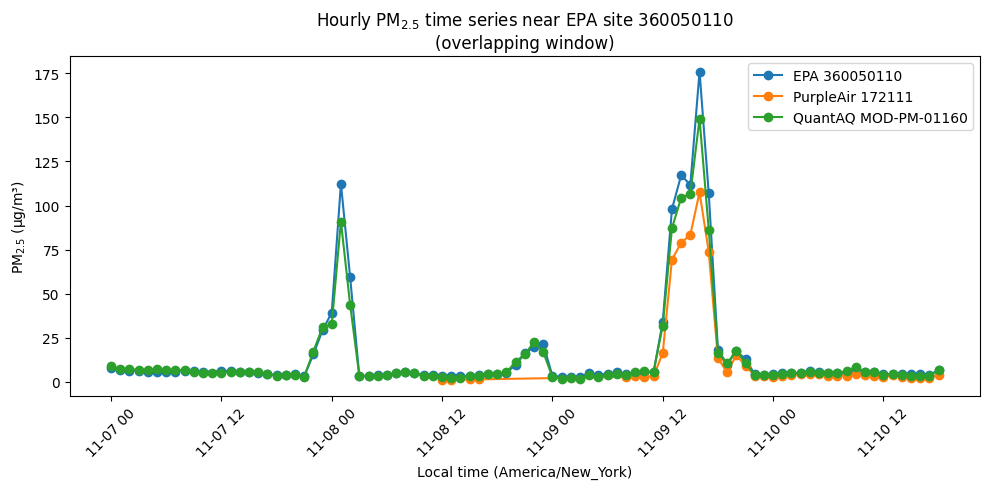


Reference EPA site: 360470118 (lat=40.6945, lon=-73.9277)
  Nearest PurpleAir sensor_id: 172111 dist2: 0.020014309353998495
  Nearest QuantAQ sensor_id:   MOD-00482 dist2: 0.009348547700000553


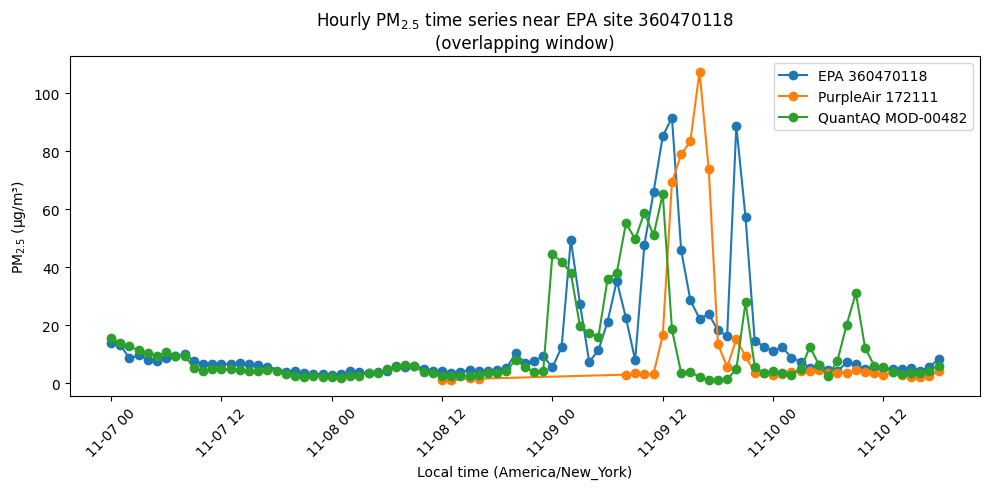

In [49]:
# Helper function: find nearest sensor in a given DataFrame
def nearest_sensor(df, ref_lat, ref_lon):
    df_ = df.dropna(subset=["lat", "lon"]).copy()
    if df_.empty:
        return None
    df_["dist2"] = (df_["lat"] - ref_lat) ** 2 + (df_["lon"] - ref_lon) ** 2
    row = df_.sort_values("dist2").iloc[0]
    return row["sensor_id"], float(row["dist2"])

# Choose a small set of EPA reference sites
epa_sites = df_epa_common["sensor_id"].unique()
print("Available EPA sites:", epa_sites)

# You can adjust N_SITES to explore further (e.g., 2,3,4...14)
N_SITES = min(2, len(epa_sites))
sites_to_plot = epa_sites[:N_SITES]
print("Plotting time series for EPA sites:", sites_to_plot)

def extract_series(df, sensor_id, label):
    sub = df[
        (df["sensor_id"] == sensor_id)
        & (df["timestamp_local"] >= overlap_start)
        & (df["timestamp_local"] <= overlap_end)
    ].copy()
    if sub.empty:
        return sub
    sub = sub.sort_values("timestamp_local")
    sub["label"] = label
    return sub[["timestamp_local", "pm25_ugm3", "label"]]

# Loop over reference sites and make one figure per site
for site_ref in sites_to_plot:
    ref_rows = df_epa_common.loc[df_epa_common["sensor_id"] == site_ref]
    ref_row = ref_rows.iloc[0]
    ref_lat = ref_row["lat"]
    ref_lon = ref_row["lon"]

    print(f"\nReference EPA site: {site_ref} (lat={ref_lat:.4f}, lon={ref_lon:.4f})")

    nearest_pa, pa_d2 = nearest_sensor(df_purpleair_common, ref_lat, ref_lon)
    nearest_qa, qa_d2 = nearest_sensor(df_quantaq_common, ref_lat, ref_lon)

    print("  Nearest PurpleAir sensor_id:", nearest_pa, "dist2:", pa_d2)
    print("  Nearest QuantAQ sensor_id:  ", nearest_qa, "dist2:", qa_d2)

    series_list = []

    # EPA series at reference site
    s_epa = extract_series(df_epa_common, site_ref, f"EPA {site_ref}")
    if not s_epa.empty:
        series_list.append(s_epa)

    # Nearest PurpleAir
    if nearest_pa is not None:
        s_pa = extract_series(df_purpleair_common, nearest_pa, f"PurpleAir {nearest_pa}")
        if not s_pa.empty:
            series_list.append(s_pa)

    # Nearest QuantAQ
    if nearest_qa is not None:
        s_qa = extract_series(df_quantaq_common, nearest_qa, f"QuantAQ {nearest_qa}")
        if not s_qa.empty:
            series_list.append(s_qa)

    if not series_list:
        print("  No data for this site in the overlapping window; skipping plot.")
        continue

    ts_all = pd.concat(series_list, ignore_index=True)

    # One plot per site
    plt.figure(figsize=(10, 5))
    for label, group in ts_all.groupby("label"):
        plt.plot(
            group["timestamp_local"],
            group["pm25_ugm3"],
            marker="o",
            linestyle="-",
            label=label,
        )

    plt.ylabel("PM$_{2.5}$ (µg/m³)")
    plt.xlabel("Local time (America/New_York)")
    plt.title(f"Hourly PM$_{{2.5}}$ time series near EPA site {site_ref}\n(overlapping window)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### How to interpret differences in PM₂.₅ across sensors and sites

When you compare PM₂.₅ across EPA AQS, PurpleAir, and QuantAQ, you should expect
differences even when sensors are near each other and even during the same hour.

Here are the main reasons:

- **Instrument type & calibration**
  - **EPA AQS** uses regulatory-grade instruments and standardized QA/QC.
  - **PurpleAir** and **QuantAQ** are lower-cost optical sensors (different internal calibrations and correction assumptions).
  - Low-cost sensors can be *systematically high or low* relative to EPA, especially under certain conditions.

- **Siting and micro-environment**
  - “Nearest sensor” may still be several blocks away, on a different street, elevation, or exposure.
  - PM₂.₅ can change sharply near traffic corridors, industrial sources, and waterfronts.

- **Time resolution & averaging**
  - **QuantAQ** often samples at higher frequency and we aggregate to hourly.
  - **PurpleAir** may have sub-hour timestamps or irregular sampling.
  - **EPA AQS** is effectively hourly in this lesson.
  - Aggregation can smooth spikes (or amplify differences if sampling windows don’t align perfectly).

- **Humidity and aerosol physics**
  - Optical PM sensors can be sensitive to humidity (particle hygroscopic growth),
    which may cause higher PM readings in humid conditions.

- **Data completeness and missing data**
  - Each network has different rules for missing values and QA flags.
  - If one sensor drops out during a peak, its “hourly mean” may not be comparable.

**How to read the plots:**
- Focus first on **timing** (do peaks occur at the same time?).
- Then compare **relative amplitude** (who reports higher vs lower during peaks?).
- Finally compare **baseline levels** (are sensors consistently offset?).

In the next section we map sensors to understand **spatial configuration** and
how network coverage can shape what you observe.


## Exploratory Data Analysis – spatial configuration of sensors

In the previous section we introduced some spatial analysis when we calculated the nearest sensor locations, but we have yet to map the sensors themselves.

In this section we:

1. Compute an event-mean PM₂.₅ for each sensor/site within the overlapping
   window, and
2. Make a simple map showing the **locations** of all sensors/sites on a
   basemap, colored by source (PurpleAir, QuantAQ, EPA AQS).

This first map is about **spatial configuration** (who is where), not about
differences in PM₂.₅ levels. 

In [50]:
# Compute event-mean PM2.5 per sensor/site within overlapping window

event_means = (
    df_all_event
    .groupby(["source", "sensor_id"])
    .agg(
        lat=("lat", "first"),
        lon=("lon", "first"),
        pm25_mean=("pm25_ugm3", "mean"),
    )
    .reset_index()
)

event_means.head()


,source,sensor_id,lat,lon,pm25_mean
0,epa_aqs,360050110,40.81600,-73.90200,15.266667
1,epa_aqs,360050112,40.81551,-73.88553,11.648352
2,epa_aqs,360470052,40.64182,-74.01871,10.224176
3,epa_aqs,360470118,40.69454,-73.92769,13.603333
4,epa_aqs,360810124,40.73614,-73.82153,14.171429


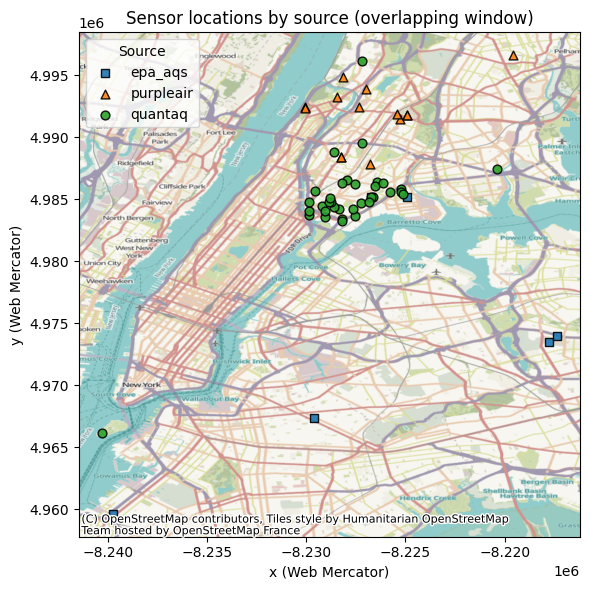

In [51]:
# Sensor locations on a basemap (spatial configuration)

# Build a GeoDataFrame from event_means
gdf = gpd.GeoDataFrame(
    event_means,
    geometry=gpd.points_from_xy(event_means["lon"], event_means["lat"]),
    crs="EPSG:4326",
)

# Reproject to Web Mercator for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Marker shapes per source
marker_map = {
    "epa_aqs": "s",       # square
    "purpleair": "^",     # triangle
    "quantaq": "o",       # circle
}

fig, ax = plt.subplots(figsize=(6, 6))

for src, group in gdf_web.groupby("source"):
    marker = marker_map.get(src, "o")
    ax.scatter(
        group.geometry.x,
        group.geometry.y,
        s=40,
        alpha=0.9,
        label=src,
        marker=marker,
        edgecolor="k",
    )

if cx is not None:
    cx.add_basemap(ax)

ax.set_xlabel("x (Web Mercator)")
ax.set_ylabel("y (Web Mercator)")
ax.set_title("Sensor locations by source (overlapping window)")
ax.legend(title="Source")
plt.tight_layout()
plt.show()


### Event-mean PM₂.₅ map

We can reuse the same geometry but encode the **event-mean** PM₂.₅ value
computed above, e.g., using marker size or color. This gives a qualitative
picture of where concentrations tend to be higher or lower during the event.


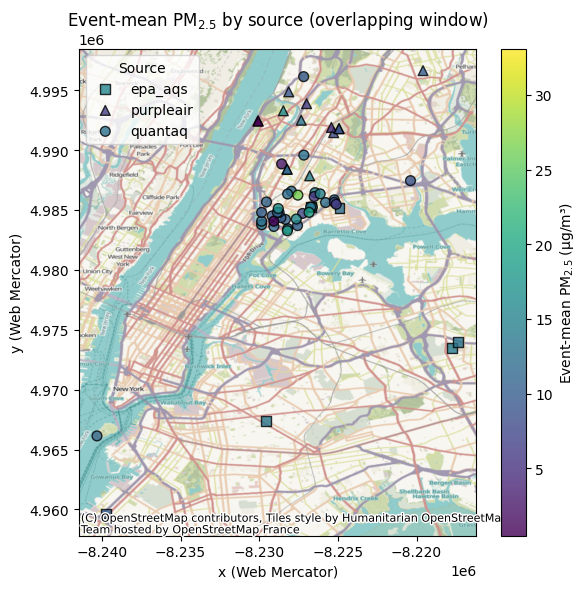

In [52]:
# Event-mean PM2.5 map with color-coded values and different shapes per source

fig, ax = plt.subplots(figsize=(6, 6))

sources = gdf_web["source"].unique()

# Global color scale across all sources
vmin = gdf_web["pm25_mean"].min()
vmax = gdf_web["pm25_mean"].max()

for src in sources:
    sub = gdf_web[gdf_web["source"] == src]
    marker = marker_map.get(src, "o")

    sc = ax.scatter(
        sub.geometry.x,
        sub.geometry.y,
        c=sub["pm25_mean"],
        vmin=vmin,
        vmax=vmax,
        s=50,
        alpha=0.8,
        label=src,
        marker=marker,
        edgecolor="k",
    )

if cx is not None:
    cx.add_basemap(ax)

ax.set_xlabel("x (Web Mercator)")
ax.set_ylabel("y (Web Mercator)")
ax.set_title("Event-mean PM$_{2.5}$ by source (overlapping window)")
ax.legend(title="Source")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Event-mean PM$_{2.5}$ (µg/m³)")

plt.tight_layout()
plt.show()


### How to interpret the spatial configuration and event-mean PM₂.₅ maps

These maps answer *two different questions*:

1. **Where are the sensors?** (spatial configuration map)  
   This map is about *coverage and sampling design*:
   - Are sensors clustered or spread out?
   - Which areas are only represented by one network?
   - Where might comparisons be biased because one network has no nearby instruments?

2. **Where was PM₂.₅ higher during the event?** (event-mean map)  
   This map summarizes PM₂.₅ into a single number per sensor (the mean over the overlapping window).
   It is useful for a *first look*, but you should interpret it carefully:
   - It can hide short, intense spikes (a site with one large peak can look similar to a site with steady moderate PM).
   - If sensors have different uptime or missing hours, their “event mean” may not be comparable.
   - Differences may reflect both real spatial patterns *and* differences in sensor type and siting.

**A good workflow:**  
Use the event-mean map to generate hypotheses (“why might this area be higher?”),
then go back to time series plots to see *when* and *how* differences occurred.



## From Ground-Based Sensors to Satellite Observations (TEMPO)

So far, we have compared **ground-based PM₂.₅** measurements across three networks.
Next we introduce **NASA TEMPO**, a satellite instrument that observes atmospheric composition.

Important context:

- TEMPO provides **vertical column** estimates of gases like **NO₂** (how much NO₂ is in a column of air above a pixel),
  not a ground-level concentration at a point.
- The spatial resolution is **coarser** than street-level sensors, and each pixel represents an area.
- The physics and measurement geometry are different from ground sensors.

That said, pairing TEMPO with ground networks is powerful for:
- building intuition about **spatial patterns**,
- exploring whether an event has a **regional signal** visible from space,
- motivating careful thinking about scale, representativeness, and uncertainty.

In the next block, we choose a **reference time** from QuantAQ NO₂ to select a TEMPO snapshot.


In [73]:
import xarray as xr

# Inspect the root TEMPO dataset
try:
    ds_root = xr.open_dataset(TEMPO_FILE)
    print("Root dataset:")
    print(ds_root)
    print("\nRoot data variables:", list(ds_root.data_vars))
except Exception as e:
    print("Could not open TEMPO_FILE at root level.")
    print("Error:", e)


Root dataset:
<xarray.Dataset> Size: 91MB
Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2024-11-09T19:22:39.021569536
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2024-11-10T01:30:58Z: L2_regrid -v /tem...
    scan_num:                         10
    time_coverage_start:              2024-11-09T19:22:21Z
    time_coverage_end:                2024-11-09T20:02:31Z
    time_coverage_start_since_epoch:  1415215359.0215695
    time_coverage_end_since_epoch:    1415217769.8787174
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    k

In [74]:
# Inspect the 'product' group (where NO2 column is stored)

try:
    ds_prod = xr.open_dataset(TEMPO_FILE, group="product")
    print("PRODUCT group dataset:")
    print(ds_prod)
    print("\nPRODUCT group data variables:", list(ds_prod.data_vars))
except Exception as e:
    print("Could not open 'product' group. Please check group name in this file.")
    print("Error:", e)


PRODUCT group dataset:
<xarray.Dataset> Size: 640MB
Dimensions:                                  (time: 1, latitude: 2950,
                                              longitude: 7750)
Dimensions without coordinates: time, latitude, longitude
Data variables:
    vertical_column_troposphere              (time, latitude, longitude) float64 183MB ...
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 183MB ...
    vertical_column_stratosphere             (time, latitude, longitude) float64 183MB ...
    main_data_quality_flag                   (time, latitude, longitude) float32 91MB ...

PRODUCT group data variables: ['vertical_column_troposphere', 'vertical_column_troposphere_uncertainty', 'vertical_column_stratosphere', 'main_data_quality_flag']


### Choosing a NO₂ snapshot time from QuantAQ

Before plotting TEMPO, we need to choose a single **reference time** for a TEMPO snapshot.

Here we will:

1. Restrict QuantAQ to the **overlapping window** used throughout the lesson.
2. Aggregate QuantAQ NO₂ to **one mean value per hour** across all QuantAQ sensors.
3. Visualize the hourly NO₂ time series and identify a “feature” (a peak or sharp change) that we want to investigate.
4. Use that hour as our **reference time** for the TEMPO snapshot.

Why do we do this?

- TEMPO snapshots are discrete in time (a TEMPO NC file represents a single observation time).
- QuantAQ provides continuous ground measurements, so we can use it to pick a time that is meaningful on the ground.

Note: a NO₂ “peak hour” may not coincide exactly with the PM₂.₅ peak hour.

In [55]:
df_event = df_all_event[
    (df_all_event["timestamp_local"] >= overlap_start)
    & (df_all_event["timestamp_local"] <= overlap_end)
].copy()

pm25_hourly_all = (
    df_event
    .groupby("timestamp_local")["pm25_ugm3"]
    .mean()
    .dropna()
    .sort_index()
)

t_peak_local = pm25_hourly_all.idxmax()
t_peak_utc = t_peak_local.tz_convert("UTC")

print("Selected peak PM2.5 hour (local):", t_peak_local)
print("Selected peak PM2.5 hour (UTC):  ", t_peak_utc)
print("All-source mean PM2.5 at peak hour:", float(pm25_hourly_all.loc[t_peak_local]))


Selected peak PM2.5 hour (local): 2024-11-09 16:00:00-05:00
Selected peak PM2.5 hour (UTC):   2024-11-09 21:00:00+00:00
All-source mean PM2.5 at peak hour: 108.41012212643679


Chosen reference hour (QuantAQ NO2 peak):
  t_peak_utc  : 2024-11-07 11:00:00+00:00
  t_peak_local: 2024-11-07 06:00:00-05:00


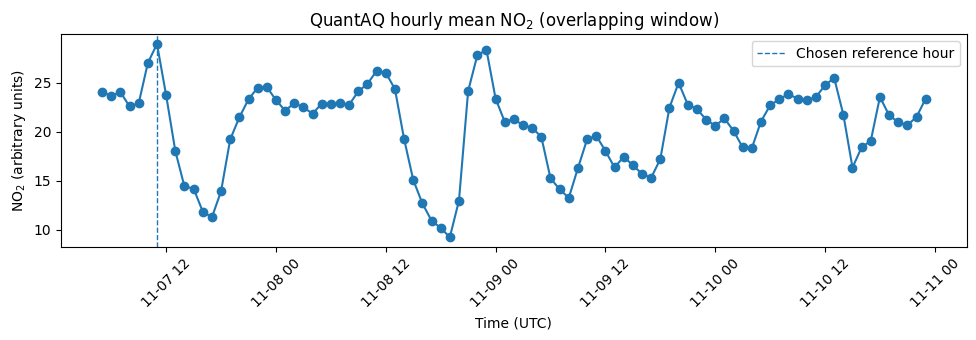

timestamp_utc
2024-11-07 05:00:00+00:00    24.046488
2024-11-07 06:00:00+00:00    23.635679
2024-11-07 07:00:00+00:00    24.045250
2024-11-07 08:00:00+00:00    22.572845
2024-11-07 09:00:00+00:00    22.886131
                               ...    
2024-11-10 19:00:00+00:00    21.682192
2024-11-10 20:00:00+00:00    20.962013
2024-11-10 21:00:00+00:00    20.652910
2024-11-10 22:00:00+00:00    21.509667
2024-11-10 23:00:00+00:00    23.366692
Name: no2, Length: 91, dtype: float64

In [75]:

# --- QuantAQ NO2: restrict to overlapping window ---
if "no2" not in df_quantaq_common.columns:
    raise ValueError(
        "Column 'no2' not found in df_quantaq_common. "
        "Please ensure NO2 is retained in the QuantAQ aggregation step."
    )

qa_event = df_quantaq_common[
    (df_quantaq_common["timestamp_local"] >= overlap_start)
    & (df_quantaq_common["timestamp_local"] <= overlap_end)
].copy()

# --- Hourly mean NO2 across QuantAQ sensors (use UTC index for easy alignment later) ---
qa_no2_hourly = (
    qa_event
    .groupby("timestamp_utc")["no2"]
    .mean()
    .dropna()
    .sort_index()
)

# --- Choose a reference hour (default: NO2 peak hour) ---
t_peak_utc = qa_no2_hourly.idxmax()
t_peak_local = t_peak_utc.tz_convert(TZ_LOCAL)

print("Chosen reference hour (QuantAQ NO2 peak):")
print("  t_peak_utc  :", t_peak_utc)
print("  t_peak_local:", t_peak_local)

# --- Plot: hourly mean NO2 and mark chosen hour ---
plt.figure(figsize=(10, 3.5))
plt.plot(qa_no2_hourly.index, qa_no2_hourly.values, marker="o", linestyle="-")
plt.axvline(t_peak_utc, linestyle="--", linewidth=1, label="Chosen reference hour")
plt.title("QuantAQ hourly mean NO$_2$ (overlapping window)")
plt.ylabel("NO$_2$ (arbitrary units)")
plt.xlabel("Time (UTC)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

qa_no2_hourly


Chosen reference hour (overall PM2.5 peak across all sources):
  t_peak_utc  : 2024-11-09 21:00:00+00:00
  t_peak_local: 2024-11-09 16:00:00-05:00


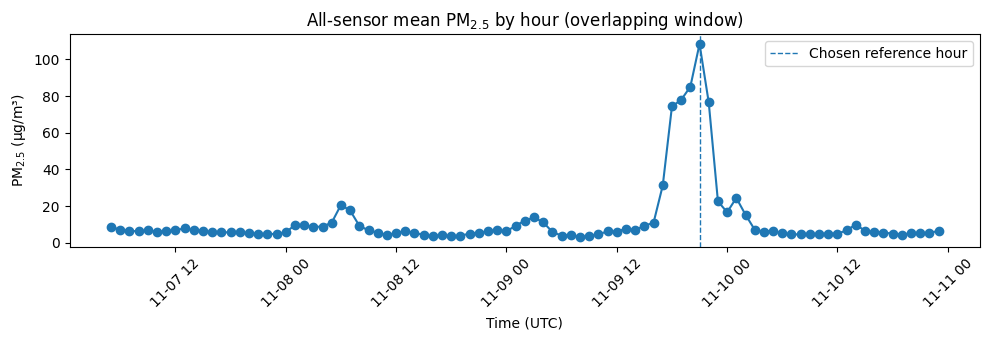

In [76]:
# OPTIONAL: choose reference hour based on the overall PM2.5 peak across all sources
pm_hourly_all = (
    df_all_event
    .groupby("timestamp_utc")["pm25_ugm3"]
    .mean()
    .dropna()
    .sort_index()
)

t_peak_utc = pm_hourly_all.idxmax()
t_peak_local = t_peak_utc.tz_convert(TZ_LOCAL)

print("Chosen reference hour (overall PM2.5 peak across all sources):")
print("  t_peak_utc  :", t_peak_utc)
print("  t_peak_local:", t_peak_local)

plt.figure(figsize=(10, 3.5))
plt.plot(pm_hourly_all.index, pm_hourly_all.values, marker="o", linestyle="-")
plt.axvline(t_peak_utc, linestyle="--", linewidth=1, label="Chosen reference hour")
plt.title("All-sensor mean PM$_{2.5}$ by hour (overlapping window)")
plt.ylabel("PM$_{2.5}$ (µg/m³)")
plt.xlabel("Time (UTC)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### TEMPO NO₂ snapshot mapped with QuantAQ NO₂ peak

Now that we have identified an interesting timeslot, we compare to our TEMPO data (we already downloaded this and include it with the lesson):

1. Inspect the TEMPO `product` group to find a NO₂ column variable (for example,
   a variable whose name contains `vertical_column` or `no2`),
2. Subset to the NYC bounding box and plot that NO₂ field with the QuantAQ stations.


In [77]:
def tempo_time_from_filename(path: str | Path) -> pd.Timestamp | None:
    """
    Extract TEMPO observation time from filename patterns like:
    TEMPO_NO2_L3_V03_20241108T172215Z_S008.nc
    Returns a tz-aware UTC pandas Timestamp, or None if not parsed.
    """
    name = Path(path).name
    m = re.search(r"_(\d{8}T\d{6})Z_", name)
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y%m%dT%H%M%S", utc=True)

tempo_obs_time_utc = tempo_time_from_filename(TEMPO_FILE)
print("TEMPO observation time (from filename):", tempo_obs_time_utc)


TEMPO observation time (from filename): 2024-11-09 19:22:21+00:00


### Note that TEMPO was not available to the exact time and that the nearest available timeslot was almost 1.5 hours before the peak QuantAQ measurements.

C:\Users\kyttm\AppData\Local\Temp\ipykernel_85704\3842760702.py:133: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


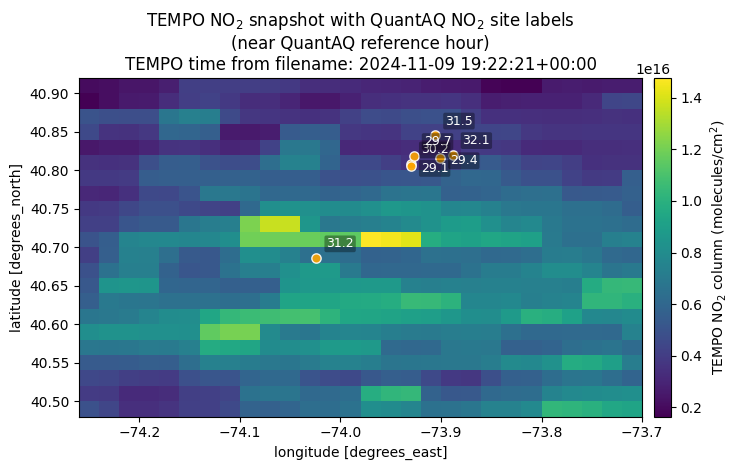

In [ ]:
# helper function
def place_nonoverlapping_labels(ax, df, x="lon", y="lat", text_col="label",
                                offsets=None, fontsize=9, bbox=None, zorder=4):
    """
    Greedy non-overlapping label placement in data coordinates.

    Tries offsets around each point and places the first label whose screen-space
    bounding box doesn't overlap existing labels.
    """
    if offsets is None:
        offsets = [
            (0.010, 0.010),  # up-right
            (0.010, -0.012), # down-right
            (-0.014, 0.010), # up-left
            (-0.014, -0.012),# down-left
            (0.000, 0.014),  # up
            (0.000, -0.016), # down
        ]

    if bbox is None:
        bbox = dict(boxstyle="round,pad=0.15", facecolor=(0, 0, 0, 0.35), edgecolor="none")

    placed_bboxes = []
    texts = []

    # Need a renderer to measure text extents
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    for _, r in df.iterrows():
        x0, y0 = float(r[x]), float(r[y])
        label = str(r[text_col])

        placed = False
        for dx, dy in offsets:
            t = ax.text(
                x0 + dx, y0 + dy, label,
                fontsize=fontsize, color="white",
                ha="left", va="bottom",
                bbox=bbox, zorder=zorder
            )
            fig.canvas.draw()
            bb = t.get_window_extent(renderer=renderer)

            # Check overlap with prior bboxes
            if any(bb.overlaps(prev) for prev in placed_bboxes):
                t.remove()
                continue

            placed_bboxes.append(bb)
            texts.append(t)
            placed = True
            break

        if not placed:
            # If all offsets overlap, keep a default placement (or skip)
            t = ax.text(
                x0 + offsets[0][0], y0 + offsets[0][1], label,
                fontsize=fontsize, color="white",
                ha="left", va="bottom",
                bbox=bbox, zorder=zorder
            )
            fig.canvas.draw()
            placed_bboxes.append(t.get_window_extent(renderer=renderer))
            texts.append(t)

    return texts


# --- Latitude/longitude may be in the product group or root dataset ---
if "latitude" in ds_prod.coords and "longitude" in ds_prod.coords:
    lat = ds_prod["latitude"]
    lon = ds_prod["longitude"]
else:
    lat = ds_root["latitude"]
    lon = ds_root["longitude"]

# --- NYC subset mask ---
lat_mask = (lat >= NYC_BBOX[1]) & (lat <= NYC_BBOX[3])
lon_mask = (lon >= NYC_BBOX[0]) & (lon <= NYC_BBOX[2])

no2_subset = no2.where(lat_mask & lon_mask, drop=True)

fig, ax = plt.subplots(figsize=(7.5, 4.8))

# --- TEMPO background ---
img = no2_subset.plot(
    x="longitude",
    y="latitude",
    cmap="viridis",
    add_colorbar=False,
    ax=ax,
)

cbar_t = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.02)
cbar_t.set_label("TEMPO NO$_2$ column (molecules/cm$^2$)")

# --- QuantAQ NO2 records near reference hour (±30 min) ---
qa_tmp = df_quantaq_common.copy()
qa_tmp["delta"] = (qa_tmp["timestamp_utc"] - t_peak_utc).abs()
# Drop rows missing location or NO2 (omit NaN points entirely)
qa_at_peak = qa_tmp[qa_tmp["delta"] <= pd.Timedelta("30min")].copy()
qa_at_peak = qa_at_peak.dropna(subset=["lat", "lon", "no2"]).copy()

# Build label column
qa_at_peak["label"] = qa_at_peak["no2"].astype(float).map(lambda v: f"{v:.1f}")

if qa_at_peak.empty:
    print("No QuantAQ NO2 records found near the reference hour.")
else:
    if "no2" not in qa_at_peak.columns:
        raise ValueError(
            "Column 'no2' not found in df_quantaq_common. "
            "Check the QuantAQ aggregation step to ensure NO2 is retained."
        )

    # For readability, sort so labels don't jump around
    qa_at_peak = qa_at_peak.sort_values("no2", ascending=False)

    # Small circles at sensor locations
    
    ax.scatter(
        qa_at_peak["lon"], qa_at_peak["lat"],
        s=45, color="orange", alpha=0.9,
        edgecolor="white", linewidth=1.0, zorder=3,
    )
    # Place labels without overlaps (greedy heuristic)
    place_nonoverlapping_labels(ax, qa_at_peak, x="lon", y="lat", text_col="label")

    # Put legend outside plot for legibility
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        frameon=True,
    )

# Optional: include filename-derived time if you computed tempo_obs_time_utc earlier
title_time = ""
if "tempo_obs_time_utc" in globals() and tempo_obs_time_utc is not None:
    title_time = f"\nTEMPO time from filename: {tempo_obs_time_utc}"

ax.set_title(
    "TEMPO NO$_2$ snapshot with QuantAQ NO$_2$ site labels\n"
    "(near QuantAQ reference hour)"
    + title_time
)
ax.set_xlabel("longitude [degrees_east]")
ax.set_ylabel("latitude [degrees_north]")

plt.tight_layout()
plt.show()



### How to interpret the TEMPO NO₂ snapshot with QuantAQ NO₂ site labels

This figure overlays two different kinds of NO₂ information:

- **TEMPO background (pixel grid):**  
  A satellite-derived estimate of **tropospheric vertical column NO₂**. Each pixel represents an *area*,
  and the value represents NO₂ integrated through a column of air.

- **QuantAQ sites (small circles + labels):**  
  Ground-based NO₂ measurements at specific locations, sampled near the chosen reference hour
  (within ±30 minutes). The **white labels** show the QuantAQ NO₂ values (in instrument units).

How to read the figure:

- Use TEMPO for **regional spatial context** (broad gradients and areas of enhancement).
- Use QuantAQ to show **local point measurements** (what sensors observed at specific sites).
- Look for **qualitative consistency**:
  - Are higher QuantAQ labeled values located in TEMPO pixels that also look elevated?
  - Do high QuantAQ points appear in relatively low TEMPO background areas (suggesting scale or representativeness issues)?

What you should *not* do:

- Do not compare numbers directly. TEMPO is a **column** measurement (molecules/cm²),
  while QuantAQ is a **ground** measurement (instrument units). Different physical quantities.

Why agreement may be weak or subtle:

- This TEMPO file is a **single snapshot**, which may miss short-lived ground spikes.
- TEMPO pixels are coarse compared to street-scale variability.
- Retrieval uncertainty and QA filtering can reduce contrast in the satellite field.

Takeaway:
This overlay is a *hypothesis generator* for spatial patterns and scale effects.
Later extensions could compare multiple TEMPO snapshots across the event window.


## Reflection – comparing sensor networks and satellite context

To wrap up, take a few minutes to reflect on what you learned in this notebook.

1. **Coverage and density**
   - How do the three ground networks (PurpleAir, QuantAQ, EPA AQS) differ in:
     - number of sensors/sites,
     - temporal coverage (before and after we restricted to the overlapping window),
     - spatial distribution?

2. **Agreement and differences**
   - Looking at the time series overlay:
     - Do the systems capture the same major features of the event (peaks, trends)?
     - Are there systematic offsets (e.g., one tends to be higher/lower)?
   - Looking at the event-mean map:
     - Do areas with higher PurpleAir values also tend to have higher QuantAQ / EPA?

3. **Data processing choices**
   - Why did we:
     - standardize everything into a common schema,
     - aggregate high-frequency data (PurpleAir, QuantAQ) to hourly,
     - restrict to an overlapping time window for the EDA?
   - How do these choices affect what conclusions we can draw?

4. **TEMPO context**
   - How does the TEMPO NO₂ snapshot complement what we can see from the ground networks?
   - What kinds of questions could TEMPO answer that the ground networks alone cannot?

5. **Limitations and next steps**
   - What are some limitations of this analysis (data coverage, quality, temporal alignment)?
   - If you had more time or data, what would you add or improve in this workflow?

*(Optional)*: Summarize your findings in a short 1–2 paragraph “mini report”
about the event and the sensor ecosystem, as if you were explaining it to a
community partner or a public health colleague.

## Conclusion – what we learned and what to do next

In this lesson we worked across three ground-based monitoring systems—**PurpleAir** (crowd-sourced low-cost),
**QuantAQ** (community/group deployed medium-cost), and **EPA AQS** (official regulatory monitoring)—and
brought them into a shared workflow. We then compared ground-based measurements with satellite measurements from 
NASA TEMPO.

### Key takeaways

- **Different networks answer different questions.**  
  EPA sites provide high-confidence reference measurements but sparse coverage. PurpleAir and QuantAQ provide
  denser coverage and community-relevant placement, but they require more careful interpretation.

- **Time handling is foundational.**  
  We explicitly carried both **UTC and local time** and defined an **overlapping window** so that comparisons
  were made on the same hours. This is essential any time you combine datasets from multiple systems.

- **A common schema enables integrated analysis.**  
  Once all sources share the same core fields (timestamps, location, sensor ID, PM₂.₅ in common units),
  we can run EDA once—tables, time series, and maps—without rewriting analysis for each data source.

- **Aggregation is not “data loss,” it is a choice.**  
  QuantAQ often samples more frequently than hourly. Aggregating to hourly means gave us an “apples-to-apples”
  comparison with the other sources, and highlighted how the averaging window can change what patterns we see.

- **Spatial context matters.**  
  Mapping sensor locations showed how network coverage can influence conclusions. The event-mean map provided a
  quick summary, but the time series plots were necessary to understand when peaks occurred and whether sensors
  tracked each other.

- **Remote sensing provides context, not a direct replacement.**  
  TEMPO NO₂ is a **tropospheric column** measurement and is not directly comparable to ground NO₂ at a point.
  We used it as a spatial and atmospheric context layer and treated comparisons as qualitative.

### Possible lesson extensions

- **Multi-site “stories”:** repeat the nearest-sensor time series comparison for additional EPA reference sites to
  understand how agreement varies by neighborhood and siting.
- **Quality flags and uncertainty:** incorporate EPA metadata fields and TEMPO quality flags to teach why QA/QC matters.
- **More TEMPO snapshots:** compare multiple TEMPO files across the event window to see how stable (or transient)
  satellite-observed patterns are.

If you remember nothing else: **align time, standardize structure, then compare**—and interpret differences as
a combination of physics, siting, and measurement design (not simply “right vs wrong sensors”).
